In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as astro_coord
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#sns.set_style("dark")

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['xtick.labelsize'] =20
#mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['legend.fontsize'] = 20
#mpl.rcParams['figure.titlesize'] = 20
import pymc3 as pm
from astropy.coordinates import Angle
import astropy.table as astrotable

splat.initializeStandards(all=True)
from scipy.interpolate import griddata, interpn
import splat.empirical as spe
%matplotlib inline


Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [3]:
PS1_DEPTHS={ 'R':23.2, 'I':23.1, 'Z':22.3, 'Y':21.4}
SDSS_DEPTHS={'R':22.2, 'I':21.3, 'Z':20.5}
VISTA_DEPTHS={'J':19.5, 'H':18.6, 'KS':17.9}
color_cuts={#'SDSS_G-SDSS_R':(1.6, 'greater'),
            #'SDSS_R-SDSS_I': (1.0, 'greater'),
            #'SDSS_I-SDSS_Z': (0.5, 'greater'),
            #'SDSS_R-SDSS_Z': (1.6, 'greater'),
            'SDSS_I-VISTA_J':(1.7, 'greater'),
            'SDSS_Z-VISTA_J':(1.1, 'greater'),
            'VISTA_J-VISTA_KS':(0.75, 'less')} 

In [4]:
#df.columns

In [5]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [6]:
#DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [7]:
#t1    = astrotable.Table.read(DATA_FOLDER+'Stripe_Defs6_ctheissen.fit') # open an FITS file
#t2    = astrotable.Table.read(DATA_FOLDER+'FieldNums_ctheissen.fit') # open an FITS file
#t3    = astrotable.join(t1, t2, keys='fieldid').to_pandas()

In [8]:
import glob

In [9]:
from astropy.io.votable import parse_single_table

In [10]:
#forget about sdss use
ffolder='/users/caganze/research/popsims/data/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [11]:
 'Hj', 'Jmag_VHS',

('Hj', 'Jmag_VHS')

In [12]:
#

In [13]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)


In [14]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [15]:
sdsscoord=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [16]:
a=Angle(sdsscoord.ra.to(u.radian))
b=Angle(sdsscoord.dec.to(u.radian))
a.wrap_at('180d', inplace=True)
b.wrap_at('180d', inplace=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


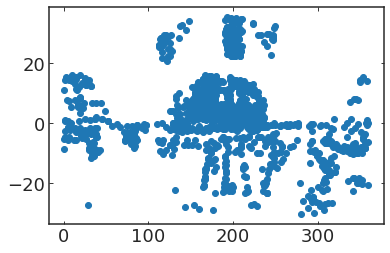

In [17]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [18]:
def interpolated(ra, dec, interpolators):
    #Ra dec must in degrees wrapped at 180 degree
    interpoints=np.array([interpolators[0], interpolators[1] ]).T
    return griddata(interpoints, interpolators[-1] , (ra, dec), \
                    method='cubic', fill_value=-1.)
def interpolated_broken(ra, dec,interpolators):
    interpoints=np.array([interpolators[0], interpolators[1] ])
    return  interpn(list(zip(interpoints)), interpolators[-1] , (ra, dec),\
                     fill_value=-1.,  bounds_error=False) 

In [19]:
from popsims.widefields import  WideField, create_mixed_population,\
transform_tocylindrical

In [20]:
#field= WideField(footprinttype='uniform')
#field.footprint=SDSS
#trace=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=1000)

In [21]:
thin_dist_list=[]
thick_dist_list=[]
halo_dist_list=[]
discr_ls=[]
discr_bs=[]

for i in tqdm(np.arange(1000)):
    c=sdsscoord[np.random.choice(len(sdsscoord))]
    narro_field=popsims.Pointing(coord=c)
    halo_field=popsims.Pointing(coord=c, density='spheroid')

    narro_field.mag_limits=dict(zip(['VISTA_{}'.format(k) for k in VISTA_DEPTHS.keys()],\
             [(0, VISTA_DEPTHS[k]) for k in VISTA_DEPTHS.keys()]))
    thin_dist_list +=list(narro_field.draw_distances(0.1, 1000,350,  nsample=1e3))
    thick_dist_list +=list(narro_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    halo_dist_list +=list(halo_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    discr_ls += [c.galactic.l.value]
    discr_bs += [c.galactic.b.value]

In [22]:
#np.save('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy',\
#        {'thind':thin_dist_list ,\
#         'thickd':thick_dist_list ,\
#         'halod': halo_dist_list,\
#         'l': discr_ls ,\
#         'b': discr_bs}, allow_pickle=True)

In [23]:
grid=np.arange(14, 40)

In [24]:
dictionary=np.load('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy', allow_pickle=True)
dist_dictionary=dictionary.flatten()[0]
thin_dist_list= dist_dictionary['thind']
thick_dist_list= dist_dictionary['thickd']
halo_dist_list= dist_dictionary['halod']
discr_ls = dist_dictionary['l']
discr_bs = dist_dictionary['b']

In [25]:
max_distances={}
for g in grid:
    pol=popsims.POLYNOMIALS['absmags']['dwarfs']['VISTA_J']['fit']
    max_distances[g]=popsims.get_distance(pol(g), 19.5)

In [26]:
def resample_distance(df, dmax_dict, population ):
    df['d']=np.nan
    if population=='thin_disk':
        ds=np.array(thin_dist_list)
    if population=='thick_disk':
        ds=np.array(thick_dist_list)
    if population=='halo':
        ds=np.array(halo_dist_list)
    ds=np.array(ds)
    df['spt_r']=np.round(df.spt)
    
    dx= ds[ds< dmax_dict[float(df.spt_r.iloc[0])] ]
    df['d']= np.random.choice(dx, len(df))
    return df
def sample_distance_properly(df, dmax_dict, population='thin_disk'):
    df['spt_r']=np.round(df.spt)
    groups=[]
    for g in tqdm( df.groupby('spt_r')):
        groups.append(resample_distance(g[1], dmax_dict, population))
    return pd.concat(groups)
def interpolate_sdss(ra, dec):
    interpolators=[a.to(u.degree).value, b.to(u.degree).value, np.ones_like(a)]
    return interpolated(ra, dec, interpolators )
def apply_sdss_selection(df):
    entiregalaxy=SkyCoord(l=df.l*u.radian,\
                     b=df.b*u.radian, frame='galactic')
    
    gridra=Angle(entiregalaxy.icrs.ra.to(u.radian))
    gridra.wrap_at('180d', inplace=True)
    griddec=Angle(entiregalaxy.icrs.dec.to(u.radian))
    griddec.wrap_at('180d', inplace=True)

    selectionfunction=interpolate_sdss(gridra.to(u.degree).value, \
                                                  griddec.to(u.degree).value)
    df['SDSS_selection']= selectionfunction
    df['ra']=gridra
    df['dec']=griddec
    return df

def apply_color_cuts(df):
    bools=[]
    for k in color_cuts.keys():
        xkey, ykey= k.split('-')
        if color_cuts[k][-1]=='greater':
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] >= color_cuts[k][0])
        if color_cuts[k][-1]=='less':
            print (k)
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] <= color_cuts[k][0])
    return np.logical_and.reduce(bools)
    

In [27]:
#df=popsims.make_systems(model='burrows1997', bfraction=0.2,\
#                            mass_age_range=[0.01, 0.15, 0., 8.0], \
#                                nsample=1e4,
#                                recompute=False)


In [28]:
from astropy.coordinates.representation import CartesianRepresentation,SphericalRepresentation, CylindricalRepresentation

In [30]:
#pm_ra, pm_dec, vr

In [32]:
get_proper_motion_cylindrical(10,11, 10, 10, 1e-15, 10)

{'RV': <Quantity -263.2039367 km / s>,
 'mu_alpha': <Quantity 10.02534144 mas / yr>,
 'mu_delta': <Quantity -6.28922805 mas / yr>}

In [34]:
#df_thin.join?

In [35]:
#SkyCoord(u=1*u.km/u.s, v=)

In [36]:
#d0=np.random.choice(thin_dist_list, int(1e6))
#d1=np.random.choice(thick_dist_list, int(1e6))
#d2=np.random.choice(halo_dist_list, int(1e6))
#l=np.random.choice, int(1e6))
#b=np.random.choice(discr_bs, int(1e6))

#r1, z1=transform_tocylindrical(l, b, d1)
#r2, z2=transform_tocylindrical(l, b, d2)

In [37]:
mag_keys0=['VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Z', \
'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'SDSS_R', 'SDSS_I', 'SDSS_Z', \
           'PANSTARRS_R', 'PANSTARRS_Z', 'PANSTARRS_I', 'PANSTARRS_Y']

In [38]:
for k in mag_keys0:
    try:
        print (popsims.POLYNOMIALS['absmags']['subdwarfs'][k]['x0'])
    except:
        print (k)


0
0
0
VISTA_H
VISTA_KS
0
0
0
0
0
SDSS_R
SDSS_I
SDSS_Z
0
0
0
0


In [39]:
#hjkl

In [40]:
tqdm.pandas()
df_thin=create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2e6, dmax_dict=max_distances,\
                  poptype='dwarfs')

dwarfs


In [41]:
#

In [42]:
#df_thin.l.isna().any(), len(df_thin)

In [43]:
df_thick=create_pop(bfraction=0.2,\
                          model='baraffe1998_metalpoor',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2e6, dmax_dict=max_distances,
                         population='thick_disk', poptype='dwarfs')

dwarfs


In [44]:
df_halo=create_pop(bfraction=0.2,\
                         model='baraffe1998_metalpoor',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2e6, dmax_dict=max_distances,
                         population='halo', poptype='subdwarfs')


subdwarfs


In [46]:
popsims.pop_mags_from_type(np.array([25]), d=np.array([1000]), keys=['VISTA_KS'],\
                           object_type='subdwarfs')

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/caganze/research/popsims/popsims/galaxy.py:153: UserWarning: Key not available for subdwarfs using dwarfs instead
  warnings.warn("Key not available for {} using {} instead".format(object_type, 'dwarfs'))


,VISTA_KS,abs_VISTA_KS
0,24.017158,14.017158


In [47]:
df_halo=df_halo.dropna(subset=['l', 'b'])
df_thick=df_thick.dropna(subset=['l', 'b'])
df_thin=df_thin.dropna(subset=['l', 'b'])

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
#df_halo.dropna?

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(-400.0, 400.0),
 (0.0, 400.0),
 Text(0.5, 0, 'V (km/s)'),
 Text(0, 0.5, ' $(U^2+ W^2)^{0.5}$(km/s)')]

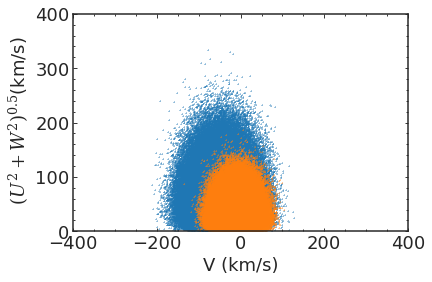

In [49]:
fig, ax=plt.subplots()
#ax.scatter(df_halo.V.values, (df_halo.U.values**2+ df_halo.W.values**2  )**0.5, \
#           alpha=0.3, s=1,  marker='+')
ax.scatter(df_thick.V.values, (df_thick.U.values**2+ df_thick.W.values**2  )**0.5, \
           s=1, alpha=0.5, marker='+')
ax.scatter(df_thin.V.values, (df_thin.U.values**2+ df_thin.W.values**2  )**0.5,\
           alpha=0.5, s=1, marker='+')
ax.minorticks_on()
ax.set(xlim=[-400, 400], ylim=[0, 400],xlabel='V (km/s)', \
       ylabel=r' $(U^2+ W^2)^{0.5}$(km/s)')

In [50]:
#jkn

In [51]:
#traceclose=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=100)

In [52]:
df_thin['population']='thin_disk'
df_thick['population']='thick_disk' 
df_halo['population']='halo'

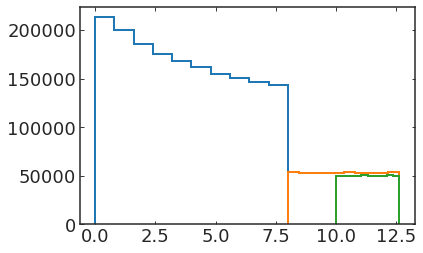

In [53]:
h=plt.hist(df_thin.age, histtype='step', lw=2, log=False)
h=plt.hist(df_thick.age, histtype='step', lw=2, log=False)
h=plt.hist(df_halo.age, histtype='step', lw=2, log=False)

In [54]:
#make a cut in spectral type
df_thin=df_thin.loc[df_thin.spt.between(14, 27)].reset_index(drop=True)
df_thick=df_thick.loc[df_thick.spt.between(14, 27)].reset_index(drop=True)
df_halo=df_halo.loc[df_halo.spt.between(14, 27)].reset_index(drop=True)

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
nsample=1e6
df0=pd.concat([df_thin.sample(n=int(nsample*0.875), replace=True), \
              df_thick.sample(n=int(nsample*0.12), replace=True), \
              df_halo.sample(n=int(nsample*0.005), replace=True)]).reset_index(drop=True)

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
#df0=df0.drop(['abs_SDSS_R', 'abs_SDSS_I', 'abs_SDSS_Z','SDSS_R', 'SDSS_I', 'SDSS_Z' ], axis=1)

In [57]:
#add SDSS and 2MASS magnitudes for darfs and subdarfs

In [58]:
#recompute SDSS relations using rocios's relations
#df=popsims.pop_mags_from_type(df0.spt.values, d=df0.d.values, \
#            keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019').join(df0)

In [59]:
df=df0.reset_index(drop=True)

In [60]:
df['abs_2MASS_J']=spe.typeToMag(df.spt.values, '2MASS J')[0]
df['abs_2MASS_H']=spe.typeToMag(df.spt.values, '2MASS H')[0]
df['abs_2MASS_K']=spe.typeToMag(df.spt.values, '2MASS K')[0]
df['2MASS_J']=df.abs_2MASS_J+5*np.log10(df.d/10.0)
df['2MASS_H']=df.abs_2MASS_H+5*np.log10(df.d/10.0)
df['2MASS_K']=df.abs_2MASS_K+5*np.log10(df.d/10.0)

#Add
sd_bool=(df.population != 'thin_disk').values
for k in ['SDSS_Z', 'SDSS_R', 'SDSS_Z', '2MASS_J', '2MASS_H', '2MASS_KS']:
    
    df.loc[sd_bool, 'abs_{}'.format(k)]= (spe.typeToMag(df.spt.values[sd_bool], \
                                          k,  reference='zhang2013')[0])
    df.loc[sd_bool, k]=df.loc[sd_bool, 'abs_{}'.format(k)]+5*np.log10(df.d.loc[sd_bool]/10.0)

In [61]:

#bools=df.SDSS_selection==1.
other_bools=[]
#other_bools.append()
for k in PS1_DEPTHS.keys():
    other_bools.append((df['PANSTARRS_{}'.format(k)]<PS1_DEPTHS[k]).values)
for k in SDSS_DEPTHS.keys():
    other_bools.append((df['SDSS_{}'.format(k)]<SDSS_DEPTHS[k]).values)
for k in VISTA_DEPTHS.keys():
    other_bools.append((df['VISTA_{}'.format(k)]<VISTA_DEPTHS[k]).values)
tot_bools=np.logical_and.reduce(other_bools)
#tot_bools=np.logical_and(tot_bools,apply_color_cuts(df))


In [62]:
len(df.loc[tot_bools])

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11730

In [63]:
#df

In [64]:
#hjhk

In [65]:
df['spt_r']=df.spt.apply(np.round)

In [66]:
dfn=df.loc[tot_bools].reset_index(drop=True)

In [67]:
np.unique(dfn.spt_r)

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 27.])

In [68]:
len(dfn)

11730

In [69]:
cmap = plt.get_cmap('cividis')
colors = cmap(np.linspace(0, 1, len(dfn.groupby('spt_r'))))

16.0 500.8407989848212
17.0 372.88213071828335
18.0 270.0420718837773
19.0 165.66059589499136
20.0 144.26439512181574
21.0 140.32890847858732
22.0 94.40064789417603
23.0 63.50425168595962
24.0 41.939439556671864
25.0 30.372635797033116
27.0 22.40527869300018


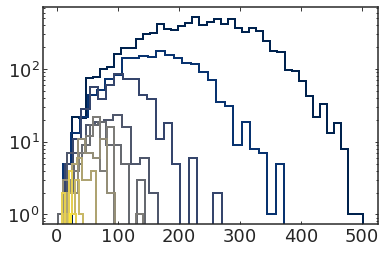

In [70]:
fig, ax=plt.subplots()
for g, co in zip(dfn.groupby('spt_r'), colors):
    print (g[0], np.nanmax(g[1].d.values))
    h=plt.hist(g[1].d.values, bins='auto', \
               histtype='step', lw=2, log=True, \
    
               label=g[1], color=co)
    

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Spectral Type')]

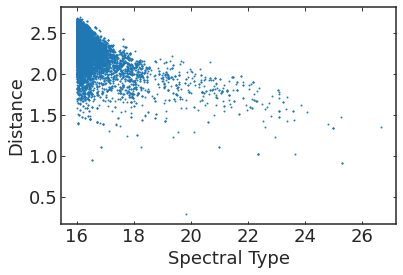

In [71]:
fig, ax=plt.subplots()
h=plt.scatter(dfn.spt, np.log10(dfn.d), s=1, alpha=0.9)
ax.set(ylabel='Distance', xlabel='Spectral Type')

[Text(0.5, 0, 'Distance')]

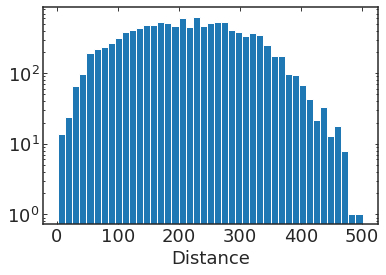

In [72]:
fig, ax=plt.subplots()
h=plt.hist(dfn.d, bins='auto', log=True)
ax.set(xlabel='Distance')

In [73]:
halo_bool=(dfn.population !='thin_disk').values

[Text(0.5, 0, 'y-z'), Text(0, 0.5, 'M$_z$')]

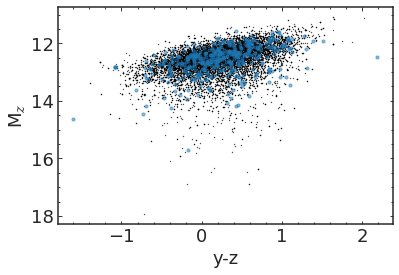

In [74]:
fig, ax=plt.subplots()
ax.scatter((dfn.VISTA_Y[~halo_bool]-dfn.VISTA_Z)[~halo_bool], \
           dfn.abs_VISTA_Z[~halo_bool],s=.1, c='k')
ax.scatter((dfn.VISTA_Y[halo_bool]-dfn.VISTA_Z)[halo_bool], \
           dfn.abs_VISTA_Z[halo_bool],s=10, alpha=0.5)
ax.minorticks_on()
ax.invert_yaxis()
ax.set(xlabel='y-z', ylabel=r'M$_z$')
#ax.scatter(df.VISTA_Y-df.VISTA_Z, df.abs_VISTA_Z,s=1)

In [75]:
#hgvjknl

In [76]:
dfn_coord=SkyCoord(l=dfn.l*u.degree, b=dfn.b*u.degree, frame='galactic')

In [77]:
dfn['ra']=dfn_coord.icrs.ra.to(u.degree)
dfn['dec']=dfn_coord.icrs.dec.to(u.degree)

In [78]:
tqdm.pandas()
motion_df=dfn[['ra', 'dec', 'd', 'U', 'V', \
       'W' ]].progress_apply(lambda x: get_proper_motion(*x), axis=1).reset_index(drop=True)

100%|██████████| 11730/11730 [01:08<00:00, 171.20it/s]


In [79]:
halo_bool=dfn.population=='halo'

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
motion_halo=pd.DataFrame(get_proper_motion_cylindrical(dfn.ra.values, \
                             dfn.dec.values,
                            (dfn.d.values)/1000,
                             dfn.Vr.values,
                            (dfn.Vphi.values)/(dfn.d.values+8300.*u.pc.to(u.km)),
                            dfn.Vz.values))

In [81]:
#len(dfj)==len(dfn)

In [82]:
dfn=dfn.reset_index(drop=True)

In [83]:
dfj=dfn.join(motion_df).reset_index(drop=True)

In [84]:
#computer proper motions for halo star
dfj.loc[halo_bool, 'RV'] = motion_halo[halo_bool]['RV'].values
dfj.loc[halo_bool, 'mu_alpha'] = motion_halo[halo_bool]['mu_alpha'].values
dfj.loc[halo_bool, 'mu_delta']= motion_halo[halo_bool]['mu_delta'].values

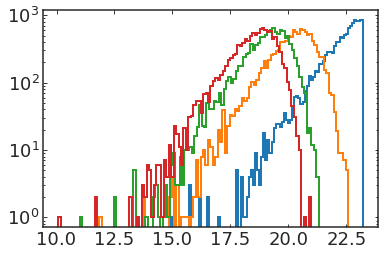

In [85]:
fig, ax=plt.subplots()
for k in PS1_DEPTHS.keys():
    #h=plt.hist(df['PANSTARRS_{}'.format(k)], bins='auto', histtype='step',\
    #           lw=2, log=True, linestyle='--')
    h=plt.hist(dfn['PANSTARRS_{}'.format(k)].values, bins='auto',\
               histtype='step', lw=2, log=True)

In [86]:
dfj.columns

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_Y', 'abs_UKIDSS_Y', 'UKIDSS_J',
       'abs_UKIDSS_J', 'UKIDSS_H', 'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K',
       'SDSS_R', 'abs_SDSS_R', 'SDSS_I', 'abs_SDSS_I', 'SDSS_Z', 'abs_SDSS_Z',
       'PANSTARRS_R', 'abs_PANSTARRS_R', 'PANSTARRS_Z', 'abs_PANSTARRS_Z',
       'PANSTARRS_I', 'abs_PANSTARRS_I', 'PANSTARRS_Y', 'abs_PANSTARRS_Y',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W', 'population', 'Vr', 'Vphi', 'Vz',
       'abs_2MASS_J', 'abs_2MASS_H', 'abs_2MASS_K', '2MASS_J', '2MASS_H',
       '2MASS_K', 'abs_2MASS_KS', '2MASS_KS', 'spt_r', 'ra', 'dec', 'RV',
       'mu_alpha', 'mu_delta',

In [87]:
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    dfj['redH_{}'.format(k)]=dfj['abs_{}'.format(k)]+\
     5*np.log10((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)+5

[Text(0.5, 0, 'Reduced Proper Motion')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


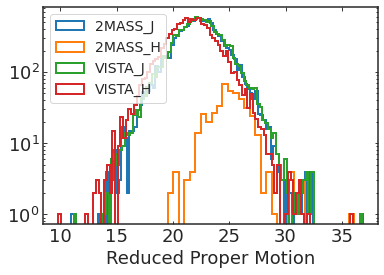

In [88]:
fig, ax=plt.subplots()
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    vals=dfj['redH_{}'.format(k)].values
    h=plt.hist(popsims.dropnans(vals),\
               bins='auto', histtype='step', lw=2, 
               log=True, label=k)
plt.legend(fontsize=14)
ax.set(xlabel='Reduced Proper Motion')

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[None,
 None,
 Text(0.5, 0, 'Proper motion (mas/yr)'),
 Text(0, 0.5, 'Distance (pc)')]

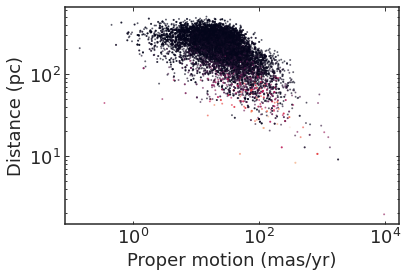

In [89]:
fig, ax=plt.subplots()

h=ax.scatter((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5, dfj.d,  c=dfj.spt, s=1, alpha=0.5)
ax.set(xscale='log', yscale='log', xlabel='Proper motion (mas/yr)', \
       ylabel='Distance (pc)', )

In [90]:
 dfj[['redH_{}'.format('VISTA_J'), 'mu_alpha']][halo_bool]

,redH_VISTA_J,mu_alpha
11728,31.760447,509.693680
11729,32.469606,-573.217828


In [91]:
#(dfj['VISTA_J']-dfj['VISTA_KS']).min()

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


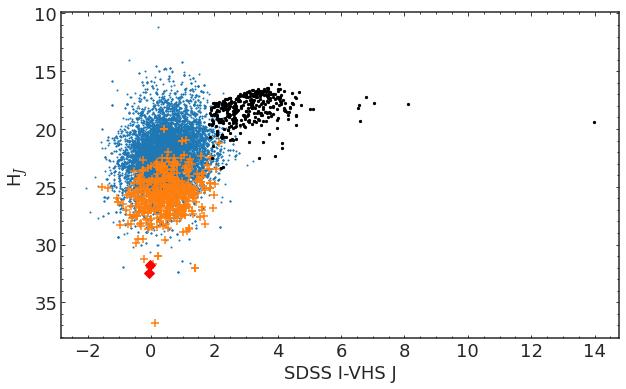

In [92]:
### color-color plots
fig, ax=plt.subplots(figsize=(10, 6))

#c=sns.scatterplot((dfj.PANSTARRS_G-dfj.PANSTARRS_R),\
#             (dfj.PANSTARRS_R-dfj.PANSTARRS_I),
#          hue='population', \
#               ax=ax[0][0], data=dfj, style='population', )

#ax[0].scatter((dfl_conct.SDSSi-dfl_conct.Jmag_VHS).values, \
#                (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS), s=5, c='k')
#ax[0].scatter((dfj.abs_SDSS_I-dfj['abs_VISTA_J']), \
#                 (dfj['VISTA_J']-dfj['VISTA_KS']), s=1)


#ax[1].scatter((dfl_conct.SDSSz-dfl_conct.Jmag_VHS).values, \
 #               (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS), s=5, c='k')
#ax[1].scatter((dfj.abs_SDSS_Z-dfj['abs_VISTA_J']), \
#                (dfj['abs_2MASS_J']-dfj['abs_VISTA_KS']), s=1)



ax.scatter((dfj.abs_SDSS_I[dfj.population=='thin_disk']-\
                dfj['abs_VISTA_J'][dfj.population=='thin_disk']), \
           dfj['redH_{}'.format('VISTA_J')][dfj.population=='thin_disk'], s=1, \
           label='thin disk')

ax.scatter((dfj.abs_SDSS_I[dfj.population=='thick_disk']-\
                dfj['abs_VISTA_J'][dfj.population=='thick_disk']), \
           dfj['redH_{}'.format('VISTA_J')][dfj.population=='thick_disk'], s=50, \
           label='thick disk', marker='+')

ax.scatter((dfj.abs_SDSS_I[halo_bool]-dfj['abs_VISTA_J'][halo_bool]), \
           dfj['redH_{}'.format('VISTA_J')][halo_bool], s=50, label='halo stars',\
               c='r', marker='D')

ax.scatter((dfl_conct.SDSSi-dfl_conct.Jmag_VHS).values, \
                dfl_conct.Hj, s=5, c='k', label='Crossmatches')




#ax[0].set(xlabel='SDSS I-J',\
#      Ylabel='SDSS J-K', xlim=[1.5, 7.])

#ax[1].set(xlabel='SDSS Z-J',\
#      Ylabel='J-K', xlim=[1., 7.])

ax.set(xlabel='SDSS I-VHS J',\
      ylabel=r'H$_J$')
#ax.legend(loc='upper left', fontsize=16)

ax.invert_yaxis()
plt.tight_layout
ax.minorticks_on()
plt.savefig(popsims.FIGURES+'/simulatedcolors_sdss_vhs.pdf')

In [93]:
#dfj.population

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
df['selection_function']=tot_bools

In [95]:
def get_ncounts(binby='spt', grid=np.arange(15, 40),
               sd=False):
    scale=[df.scale.mean(), df.scale_unc.mean(),df.scale_times_model.mean()]
    NSIM=dict(zip(grid, np.zeros((len(grid), 2))))
    df['r_{}'.format(binby)]=df[binby].apply(np.round)

    for g in tqdm(df.groupby('r_{}'.format(binby))):
        sn= len(df[np.logical_and(df.temperature>=450, df.temperature<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        
        if sd:
            b0=np.logical_and(df.temperature>=450, df.temperature<=2100)
            b1=df.population=='halo'
            nhalo=len(df[np.logical_and(b0, b1)])/sn
            scln=scln*nhalo

        
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].selection_function)*scln
    df.drop('r_{}'.format(binby), axis=1)
    return pd.DataFrame(NSIM).T.rename(columns={0: 'N', 1: 'Nunc'})

In [96]:
grid

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39])

In [97]:

counts=get_ncounts(grid=grid)
sdcounts=get_ncounts(grid=grid, sd=True)

100%|██████████| 14/14 [00:02<00:00,  4.83it/s]


In [98]:
import scipy.integrate as integrate
from popsims.widefields import galactic_density

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
def compute_volume(spt, l, b, h=350):
    dmin=0
    dmax=max_distances[spt]
    if np.isnan(dmax):
        return np.nan
    else:
        ds=np.linspace(dmin, dmax, 1000)
        rd=np.sqrt( (ds * np.cos( b ) )**2 + popsims.Rsun * (popsims.Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
        zd=popsims.Zsun+ ds * np.sin( b - np.arctan( popsims.Zsun / popsims.Rsun) )
        rh=galactic_density(rd, zd, h)
        return {'thin': integrate.trapz(rh['thin']*(ds**2), x=ds), \
                'thick': integrate.trapz(rh['thick']*(ds**2), x=ds), \
                'halo': integrate.trapz(rh['halo']*(ds**2), x=ds)}
                

In [100]:
grid

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39])

In [101]:
volumes={}
for k in grid:
    vs={'thin': 0.0, 'thick': 0.0, 'halo': 0.0}
    for f in tqdm(dfn_coord):
        l=f.l.radian
        b=f.b.radian
        v=compute_volume(k, l, b, h=350)
        vs['thin'] +=v['thin']
        vs['thick'] +=v['thick']
        vs['halo'] +=v['halo']
    volumes[k]=vs

100%|██████████| 11730/11730 [00:14<00:00, 813.67it/s] 


In [102]:
#save this, takes too much time to do
volumes_df=pd.DataFrame(volumes).T

In [103]:
area=5350*(u.degree**2).to(u.radian**2)/len(dfn_coord)

In [104]:
#area

In [105]:
#easiest ay is to compute volumes for every field and then
#second easiest thing, simulate an entire sky and do 2d-interpolation over sdss area

In [106]:
#counts['volume']=pd.Series(volumes).T/len(dfn_coord)
#sdcounts['volume']=pd.Series(volumes).T/len(dfn_coord)

In [107]:
#counts.N

[Text(0, 0.5, 'N/radian$^2$')]

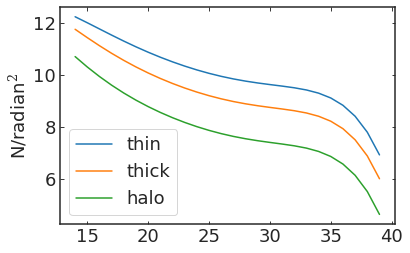

In [108]:
fig, ax=plt.subplots()
volumes_df.thin.apply(np.log10).plot(label='thin', ax=ax)
volumes_df.thick.apply(np.log10).plot(label='thick', ax=ax)
volumes_df.halo.apply(np.log10).plot(label='halo', ax=ax)
ax.legend()
ax.set(ylabel=r'N/radian$^2$')



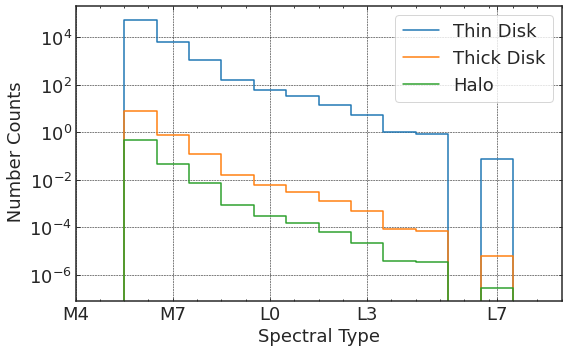

In [113]:
fig, ax=plt.subplots(figsize=(8, 5))

ax.step(counts.index, counts.N*volumes_df.thin*area, label='Thin Disk', where='mid')
ax.step(sdcounts.index,sdcounts.N*volumes_df.thick*area,label='Thick Disk', where='mid')
ax.step(sdcounts.index, sdcounts.N*volumes_df.halo*area,label='Halo', where='mid')
ax.set( xlabel='Spectral Type',  ylabel=r' Number Counts', yscale='log', xlim=[14, 29] )
ax.grid()
#ax.axhline(100, linestyle='--', c='k')
plt.legend()
plt.tight_layout()
ax.minorticks_on()
ax.set_xticks([14, 17, 20,  23, 27])
ax.set_xticklabels(['M4', 'M7', 'L0', 'L3', 'L7'])
plt.savefig(popsims.FIGURES+'/simulatedncounts_sdss_vhs.pdf')

In [110]:
np.isnan(discr_ls).any()

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

In [111]:
#read in a metal-poor baraffe model
#baraffe=pd.read_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998.csv')
#metpoor=(baraffe[baraffe.metallicity<0]).reset_index(drop=True)

In [112]:
#metpoor.to_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998_metalpoor.csv', index=False)